# Analysis on campaign effect with Bayesian method 

How effective is this online advertisement? This is always the main question for every campaign. In this project, we will investigate a set of data contains the campaigns in different network sources and use the Bayesian method to answer this question in 2 levels:

1. **How many** people paid in each network and the difference among them? (Number of payers)
2. **How much** people paid in each network and the difference among them? (Total revenue)

Obviously, these 2 questions are closely related: question 1 can be considered as a classification question and question 2 is an extension to question 1 with *revenue*.

In [1]:
import pandas as pd
import numpy as np
import theano.tensor as tt
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

## Data

The dataset contains 4 columns: 

- `userid`: 10832 Individual data point
- `network`: 4 different networks as the source of a campaign to be compared
- `amount_eur`: Total revenue generated from a user in a period
- `payer`: Binary classifier on the user, 1 for the payer.

In [2]:
## Data set
data = pd.read_csv('ads_data')
data.head(3)

,userid,network,amount_eur,payer
0,43340,Network_1,0.0,0
1,43348,Network_1,0.0,0
2,43854,Network_2,0.0,0


## 1. Number of Payer

Since payer is a binary classifier, Bernoulli distribution will be an ideal distribution to describe. 

$$
payer: P(x|\theta) = Bernoulli(\theta)
$$

In [3]:
data.groupby('network').agg(['count','mean'])['payer']

,count,mean
network,,
Network_1,1036,0.003861
Network_2,2552,0.010188
Network_4,2047,0.016121
Network_5,5197,0.009429


From the above table, we can notice the number of user in each network are different. Meanwhile, we also have the ratio of payers which is very low. However, how confident are we with these numbers? Bayesian will help us a little bit.

### Modelling on payer
With pymc3, we will draw 500 samples from a network and run 5000 times to simulate their posterior distribution.

In [4]:
with pm.Model() as r2p_model:
    
    ### sampling for network 5    
    N5 = data.loc[data['network']=='Network_5','payer'] # data    
    theta5 = pm.Beta('theta5', 1, 3) # define the prior    
    like5 = pm.Bernoulli('like5', theta5, observed = N5) # define the likelihood
    
    ### same procedure for network 2
    N2 = data.loc[data['network']=='Network_2','payer']
    theta2 = pm.Beta('theta2', 1, 3)
    like2 = pm.Bernoulli('like2', theta2, observed = N2)
    
    ### same procedure for network 4
    N4 = data.loc[data['network']=='Network_4','payer']
    theta4 = pm.Beta('theta4', 1, 3)
    like4 = pm.Bernoulli('like4', theta4, observed = N4)
    
    ### same procedure for network 1
    N1 = data.loc[data['network']=='Network_1','payer']
    theta1 = pm.Beta('theta1', 1, 3)
    like1 = pm.Bernoulli('like1', theta1, observed = N1)
    
    # We will also explicitly compute the difference between different networks 
    theta_diff_5_2 = pm.Deterministic("theta_diff_5_2", theta5 - theta2)
    theta_diff_5_4 = pm.Deterministic("theta_diff_5_4", theta5 - theta4)
    theta_diff_5_1 = pm.Deterministic("theta_diff_5_1", theta5 - theta1)
    theta_diff_2_4 = pm.Deterministic("theta_diff_2_4", theta2 - theta4)
    theta_diff_2_1 = pm.Deterministic("theta_diff_2_1", theta2 - theta1)
    theta_diff_4_1 = pm.Deterministic("theta_diff_4_1", theta4 - theta1)

In [5]:
with r2p_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta1, theta4, theta2, theta5]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:09<00:00, 1125.74draws/s]


/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


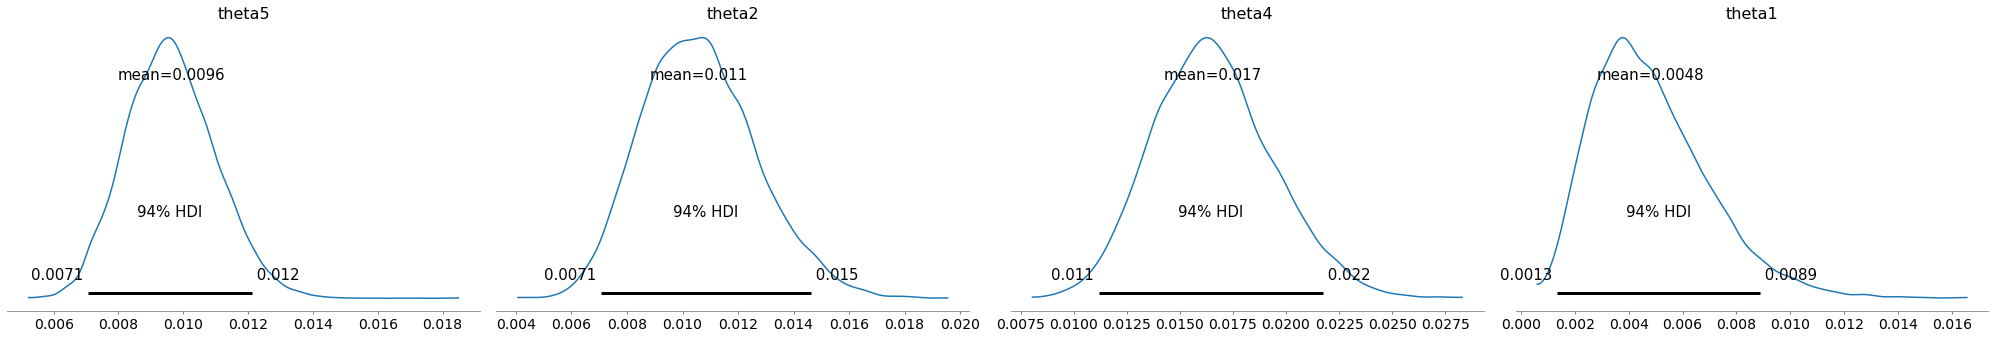

In [6]:
az.plot_posterior(trace, var_names = ['theta[0-9]'], filter_vars = 'regex', round_to=2);

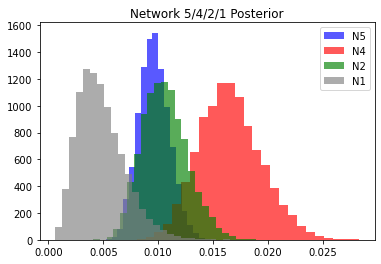

In [7]:
plt.hist(trace['theta5'], histtype='stepfilled', bins=25, alpha=0.65, color = 'blue', label='N5') # Network 5
plt.hist(trace['theta4'], histtype='stepfilled', bins=25, alpha=0.65, color = 'red', label='N4') # Network 4
plt.hist(trace['theta2'], histtype='stepfilled', bins=25, alpha=0.65, color = 'green', label='N2') # Network 2
plt.hist(trace['theta1'], histtype='stepfilled', bins=25, alpha=0.65, color = 'grey', label='N1') # Network 1

plt.title('Network 5/4/2/1 Posterior')
plt.legend(loc="upper right")

Above plots shown the probability distrbutions of the true mean of payer ratio from each network. Instead of a single number, we have a 94% credible interval as follow:

- Network 5: 0.0071 - 0.0120, mean = 0.0096
- Network 2: 0.0071 - 0.0150, mean = 0.0110
- Network 4: 0.0110 - 0.0220, mean = 0.0170
- Network 1: 0.0012 - 0.0090, mean = 0.0048

There is a little overlap in the range among networks 4, 5 & 2. Under this circumstance, can we still say network 4 has the best payer rate? 

In [8]:
networks = data['network'].unique()
payer_compare = pd.DataFrame(columns = networks, index = networks)

i=0
for data1 in [trace['theta1'], trace['theta2'], trace['theta4'], trace['theta5']]:
    j=0
    for data2 in [trace['theta1'], trace['theta2'], trace['theta4'], trace['theta5']]:
        payer_compare.loc[networks[i],networks[j]] = sum(data1 > data2)/len(data1)
        j+=1
    i+=1

print('Prob of networks in row great than columns:')
payer_compare

Prob of networks in row great than columns:


,Network_1,Network_2,Network_4,Network_5
Network_1,0,0.0315,0.0004,0.0386
Network_2,0.9685,0,0.0416,0.6466
Network_4,0.9996,0.9584,0,0.9911
Network_5,0.9614,0.3534,0.0089,0


The above table shows the ratio that the networks in the row has a greater payer ratio than the networks in the column, based on our sampling. The distribution below shows that 94% chance of the range of difference between the two networks.

/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


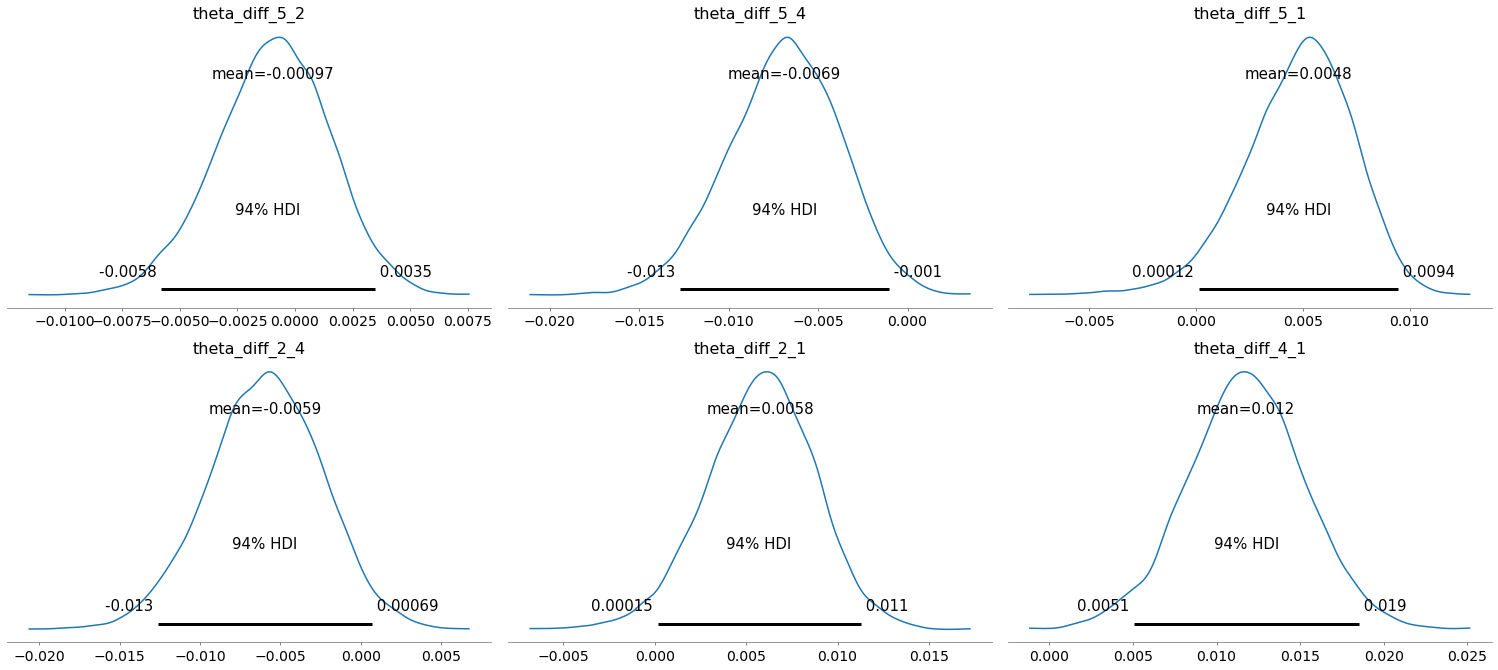

In [9]:
az.plot_posterior(trace, var_names = ['^theta_diff'], filter_vars = 'regex', round_to=2);

## 2. Revenue

Considering the situation that most of the players are not payers, a zero-inflated exponential distribution will be a choice for estimating revenue.

$$
revenue: f(x|p,\lambda) = 
\begin{cases}p  & \text{if } x = 0 \cr
(1-p) \lambda\exp(-\lambda x) & \text{if } x \gt 0
\end{cases}
$$

In fact, *1-p* should be exactly the *theta* in estimating the number of payers. Therefore, the information we found before is inclusive in this model. Since zero-inflated exponential distribution is not regular in pymc3, we have to build our own function.

In [10]:
def zero_inflated_exp(x, p_zero, lam):
    """
    Returns the log-probability of an exponential distribution,
    with a fixed probability of seeing a zero instead.
    """
    return tt.switch(
        tt.eq(x, 0.),
        tt.log(p_zero),
        tt.log(lam - (lam * p_zero)) - (lam * x)
    )

In [11]:
# Combined model

with pm.Model() as combined_model:
    
    ### Network 5
    N5 = data.loc[data['network']=='Network_5','amount_eur'] # data
    p_zero_5 = pm.Beta('p_zero_5', 5, 1) # zero inflated part
    lam5 = pm.HalfNormal('lam5', sd = 2) # Exponential part   
    like5 = pm.DensityDist('like5', zero_inflated_exp, 
                           observed = {'x': N5,
                                       'p_zero': p_zero_5, 
                                       'lam': lam5})   

    exp_revenue_5 = pm.Deterministic("exp_revenue_5", (1-p_zero_5)*(1/lam5)) # expected revenue
    
    ### Network 2
    N2 = data.loc[data['network']=='Network_2','amount_eur']
    p_zero_2 = pm.Beta('p_zero_2', 5, 1)    
    lam2 = pm.HalfNormal('lam2', sd = 2)    
    
    like2 = pm.DensityDist('like2', zero_inflated_exp, 
                           observed = {'x': N2,
                                       'p_zero': p_zero_2, 
                                       'lam': lam2})
    
    exp_revenue_2 = pm.Deterministic("exp_revenue_2", (1-p_zero_2)*(1/lam2))
    
    ### Network 4
    N4 = data.loc[data['network']=='Network_4','amount_eur']
    p_zero_4 = pm.Beta('p_zero_4', 5, 1)    
    lam4 = pm.HalfNormal('lam4', sd = 2)    
    
    like4 = pm.DensityDist('like4', zero_inflated_exp, 
                           observed = {'x': N4,
                                       'p_zero': p_zero_4, 
                                       'lam': lam4})
    
    exp_revenue_4 = pm.Deterministic("exp_revenue_4", (1-p_zero_4)*(1/lam4))

    ### Network 1
    N1 = data.loc[data['network']=='Network_1','amount_eur']
    p_zero_1 = pm.Beta('p_zero_1', 5, 1)    
    lam1 = pm.HalfNormal('lam1', sd = 2)    
    
    like1 = pm.DensityDist('like1', zero_inflated_exp, 
                           observed = {'x': N1,
                                       'p_zero': p_zero_1, 
                                       'lam': lam1})

    exp_revenue_1 = pm.Deterministic("exp_revenue_1", (1-p_zero_1)*(1/lam1))
    
    # difference between different networks
    rev_diff_5_4 = pm.Deterministic("rev_diff_5_4", exp_revenue_5 - exp_revenue_4)
    rev_diff_5_2 = pm.Deterministic("rev_diff_5_2", exp_revenue_5 - exp_revenue_2)
    rev_diff_5_1 = pm.Deterministic("rev_diff_5_1", exp_revenue_5 - exp_revenue_1)
    rev_diff_4_2 = pm.Deterministic("rev_diff_4_2", exp_revenue_4 - exp_revenue_2)
    rev_diff_4_1 = pm.Deterministic("rev_diff_4_1", exp_revenue_4 - exp_revenue_1)
    rev_diff_2_1 = pm.Deterministic("rev_diff_2_1", exp_revenue_2 - exp_revenue_1)

In [12]:
# fixing version conflict between aviz and pymc by using idata
with combined_model:
    trace = pm.sample(5000, compute_convergence_checks=False)
    idata = az.from_pymc3(trace, density_dist_obs=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam1, p_zero_1, lam4, p_zero_4, lam2, p_zero_2, lam5, p_zero_5]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:11<00:00, 922.98draws/s]


In [13]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

### p_zero

array([<AxesSubplot:title={'center':'p_zero_5'}>,
       <AxesSubplot:title={'center':'p_zero_2'}>,
       <AxesSubplot:title={'center':'p_zero_4'}>,
       <AxesSubplot:title={'center':'p_zero_1'}>], dtype=object)

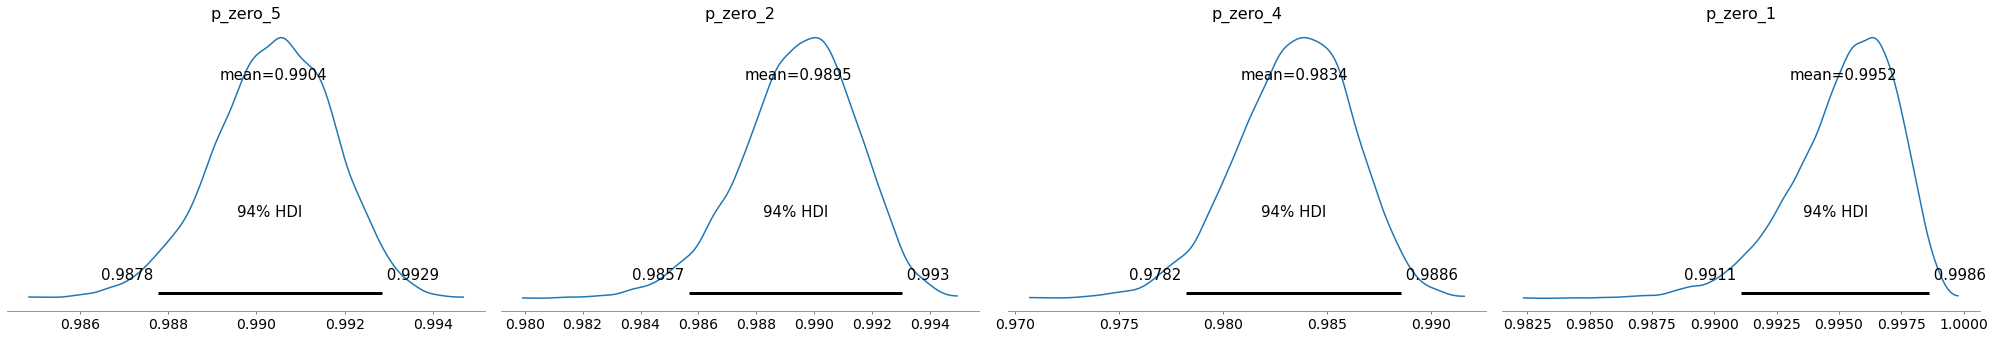

In [14]:
az.plot_posterior(idata.get('posterior'), var_names=['^p_zero'], filter_vars = 'regex', round_to=4)

The *p_zero* of each network are very close but not identical to the result in part 1 due to randomness.

### Lambda

array([<AxesSubplot:title={'center':'lam5'}>,
       <AxesSubplot:title={'center':'lam2'}>,
       <AxesSubplot:title={'center':'lam4'}>,
       <AxesSubplot:title={'center':'lam1'}>], dtype=object)

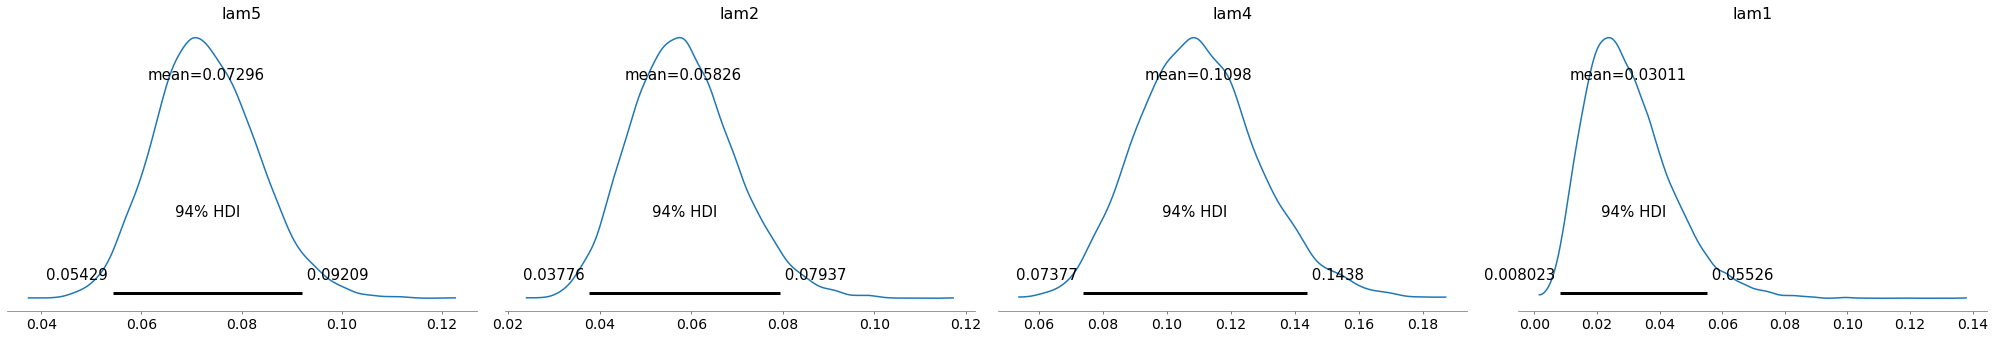

In [15]:
az.plot_posterior(idata.get('posterior'), var_names=['^lam'], filter_vars = 'regex', round_to=4)

$\lambda$ is the parameter to control the exponential part of the formula. We can use $(1-p)/\lambda$ to return the expected revenue of each network.

In [16]:
# mean of revenue 
data.groupby('network').agg(['mean','sum','count'])['amount_eur']

,mean,sum,count
network,,,
Network_1,0.160097,165.86,1036
Network_2,0.182128,464.79,2552
Network_4,0.151353,309.82,2047
Network_5,0.131728,684.59,5197


array([<AxesSubplot:title={'center':'exp_revenue_5'}>,
       <AxesSubplot:title={'center':'exp_revenue_2'}>,
       <AxesSubplot:title={'center':'exp_revenue_4'}>,
       <AxesSubplot:title={'center':'exp_revenue_1'}>], dtype=object)

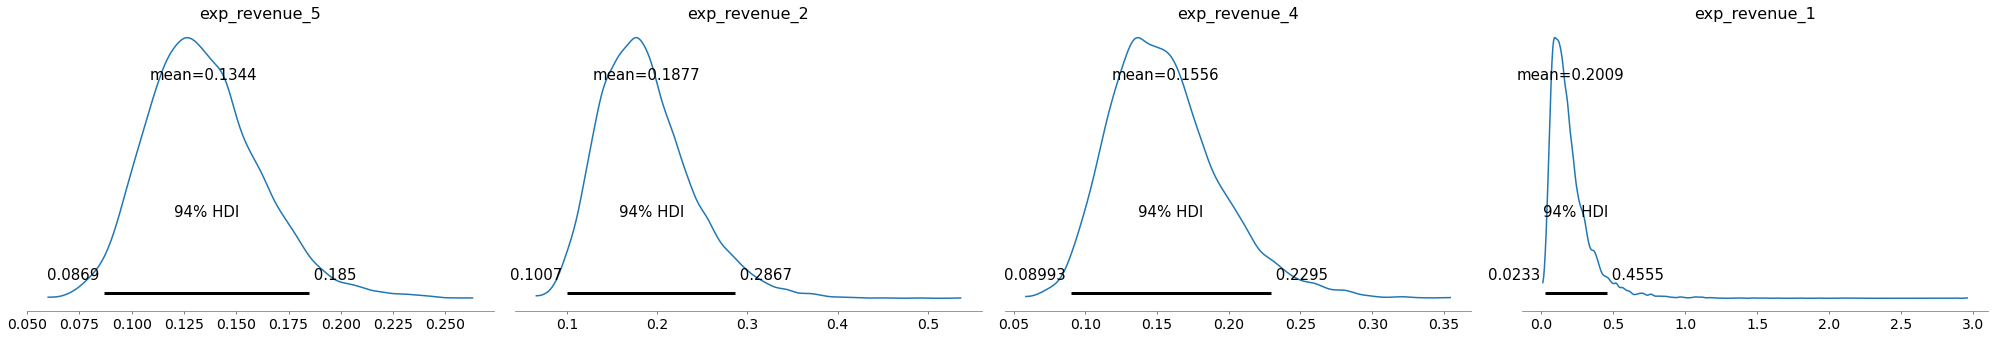

In [17]:
az.plot_posterior(idata.get('posterior'), var_names=['^exp_re'], filter_vars = 'regex', round_to=4)

The 94% creditable interval of expected revenue of each network are as follow:

- Network 5: 0.0846 - 0.1837, mean 0.1344
- Network 2: 0.1025 - 0.2895, mean 0.1880
- Network 4: 0.0904 - 0.2264, mean 0.1549
- Network 1: 0.0218 - 0.4574, mean 0.2009

We can notice the range size of networks 4 & 5 is around 0.1, network 2 is 0.2, and network 1 is more than 0.4. The main reason for the difference in size is the number of available samples. If the available sample size is small, we will be relatively not so confident with the actual value. Hence, we have higher expected revenue from network 1 but still hard to be confident that it is the best among all networks.

array([[<AxesSubplot:title={'center':'rev_diff_5_4'}>,
        <AxesSubplot:title={'center':'rev_diff_5_2'}>,
        <AxesSubplot:title={'center':'rev_diff_5_1'}>],
       [<AxesSubplot:title={'center':'rev_diff_4_2'}>,
        <AxesSubplot:title={'center':'rev_diff_4_1'}>,
        <AxesSubplot:title={'center':'rev_diff_2_1'}>]], dtype=object)

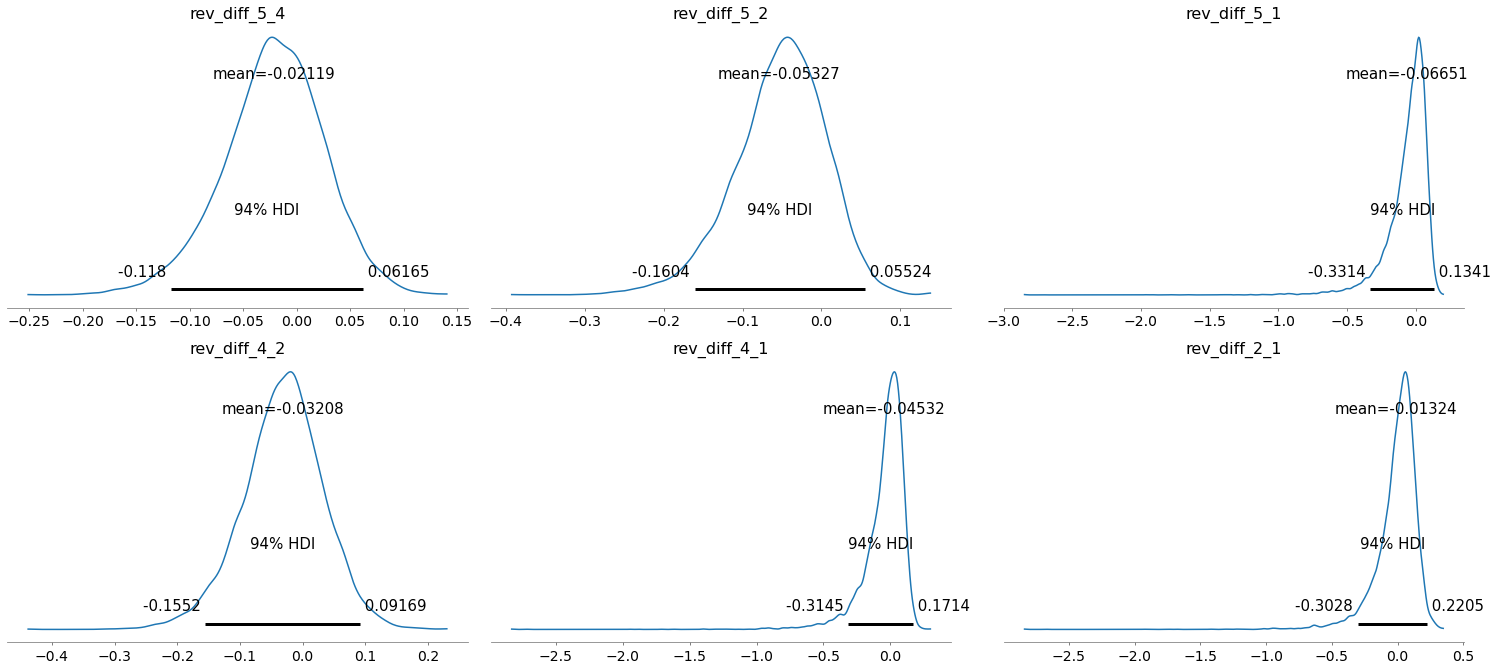

In [18]:
az.plot_posterior(idata.get('posterior'), var_names=['^rev_diff'], filter_vars = 'regex', round_to=4)

In [19]:
networks = data['network'].unique()
rev_compare = pd.DataFrame(columns = networks, index = networks)

i=0
for data1 in [trace['exp_revenue_5'], trace['exp_revenue_2'], trace['exp_revenue_1'], trace['exp_revenue_4']]:
    j=0
    for data2 in [trace['exp_revenue_5'], trace['exp_revenue_2'], trace['exp_revenue_1'], trace['exp_revenue_4']]:
        rev_compare.loc[networks[i],networks[j]] = sum(data1 > data2)/len(data1)
        j+=1
    i+=1

print('Prob of the revenue from networks in row great than in columns:')
rev_compare

Prob of the revenue from networks in row great than in columns:


,Network_1,Network_2,Network_4,Network_5
Network_1,0,0.1719,0.3946,0.3327
Network_2,0.8281,0,0.5645,0.6946
Network_4,0.6054,0.4355,0,0.536
Network_5,0.6673,0.3054,0.464,0


## Conclusion

Network 4 has the best payer rate with a mean of 0.017, while network 1 is the worst with a mean of 0.0048. 
Regarding the revenue, network 2, 4 & 5 do not have a significant difference between each other since they have a relatively large range of variance as follow:

- Network 5: 0.0846 - 0.1837, mean 0.1344
- Network 2: 0.1025 - 0.2895, mean 0.1880
- Network 4: 0.0904 - 0.2264, mean 0.1549